In [1]:
import h5py
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from shd import SHD, SHDSample
from IPython.display import display, Audio

In [2]:
dataset = SHD("data", train=True, download=True)

print("label_names:", dataset.label_names)

label_names: ['zero' 'one' 'two' 'three' 'four' 'five' 'six' 'seven' 'eight' 'nine'
 'null' 'eins' 'zwei' 'drei' 'vier' 'fuenf' 'sechs' 'sieben' 'acht' 'neun']


## Look at some samples

In [3]:

def show_sample_info(dataset: SHD, i):
    sample = dataset[i]
    label_name = dataset.label_names[sample.label_index]

    print(f"Sample #{i}:")
    print(f"  Label: '{label_name}' ({sample.label_index})")

    T = sample.times[-1]
    print(f"  Trial length: {T:.3f}s")

    print(f"  Spike count: {len(sample.times)}")
    print(f"  Avg. firing rate: {len(sample.times) / T / 1e3:.3g}kHz")

    speaker = dataset.get_speaker(sample.speaker_index)
    print(f"  Speaker: #{sample.speaker_index} (gender: {speaker.gender}, age: {speaker.age}, body height: {speaker.body_height}cm)")
    
    n_active = np.unique(sample.units).size
    print(f"  Active neurons: {n_active} ({n_active / 700 * 100:.3g}%)")

    if sample.audio_filename is not None:
        print(f"  Audio: {sample.audio_filename}")
        display(Audio(dataset.get_audio_path(sample.audio_filename)))

In [4]:
for index in range(3):
    show_sample_info(dataset, index)

Sample #0:
  Label: 'eins' (11)
  Trial length: 0.701s
  Spike count: 4278
  Avg. firing rate: 6.11kHz
  Speaker: #2 (gender: female, age: 23, body height: 158.0cm)
  Active neurons: 545 (77.9%)
  Audio: lang-english_speaker-00_trial-4_digit-5.flac


Sample #1:
  Label: 'drei' (13)
  Trial length: 0.881s
  Spike count: 12118
  Avg. firing rate: 13.8kHz
  Speaker: #11 (gender: female, age: 31, body height: 163.0cm)
  Active neurons: 604 (86.3%)
  Audio: lang-english_speaker-00_trial-34_digit-3.flac


Sample #2:
  Label: 'five' (5)
  Trial length: 0.739s
  Spike count: 4896
  Avg. firing rate: 6.62kHz
  Speaker: #0 (gender: male, age: 24, body height: 180.0cm)
  Active neurons: 549 (78.4%)
  Audio: lang-english_speaker-00_trial-4_digit-0.flac


## Plot a few samples

In [5]:
def plot_sample(sample: SHDSample, *, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    kwargs.setdefault("alpha", 1)
    kwargs.setdefault("s", 0.1)
    kwargs.setdefault("c", "black")

    ax.scatter(sample.times, sample.units, **kwargs)

    
def plot_samples(dataset: SHD, label_indices, nrows):
    ncols = len(label_indices)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), sharex=True, sharey=True, dpi=200)

    for col, label_index in enumerate(label_indices):
        label_name = dataset.label_names[label_index]
        axs[0, col].set_title(f"'{label_name}'")

        row = 0

        for index, sample in enumerate(dataset): # type: ignore
            if sample.label_index != label_index: continue

            ax = axs[row, col]
            plot_sample(sample, ax=ax)
            ax.text(0.98, 0.02, f"#{index}", transform=ax.transAxes, ha="right", va="bottom")

            ax.axvline(0)
            ax.axvline(sample.times.max())

            row += 1
            if row == nrows:
                break


    for ax in axs[-1]:
        ax.set_xlabel("Time")

    for ax in axs[:, 0]:
        ax.set_ylabel("Neuron")

    plt.tight_layout()
    plt.show()

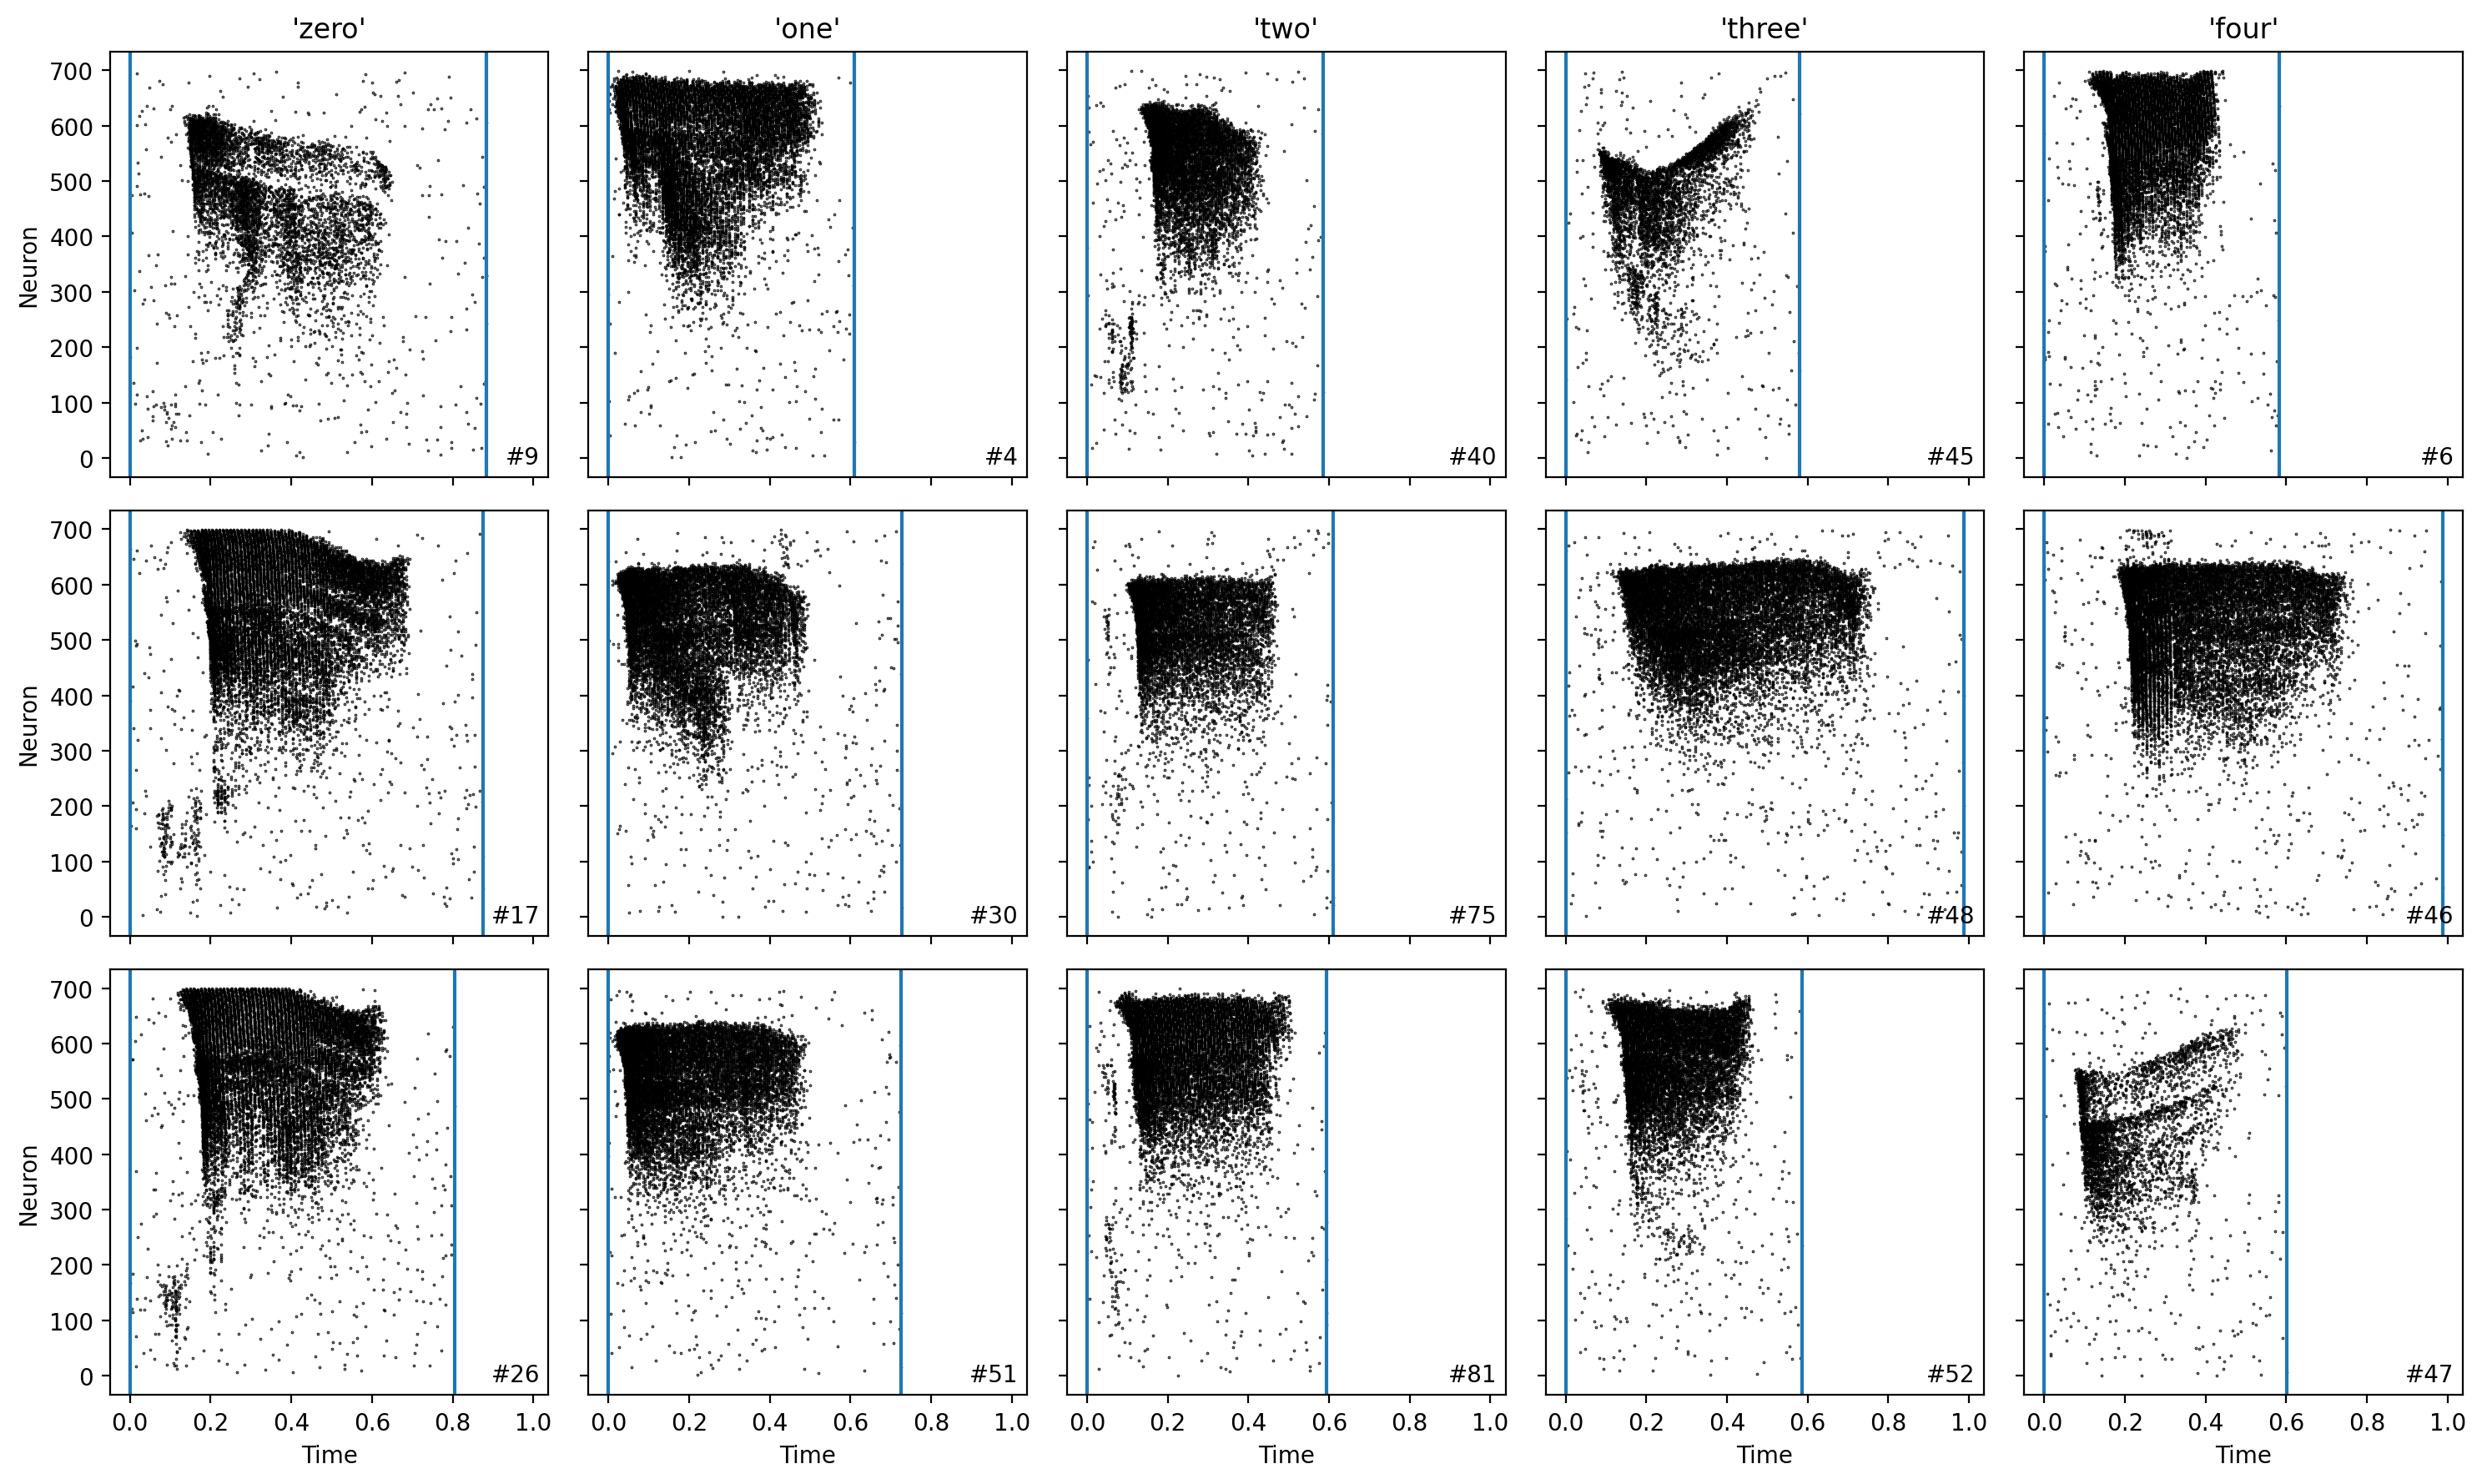

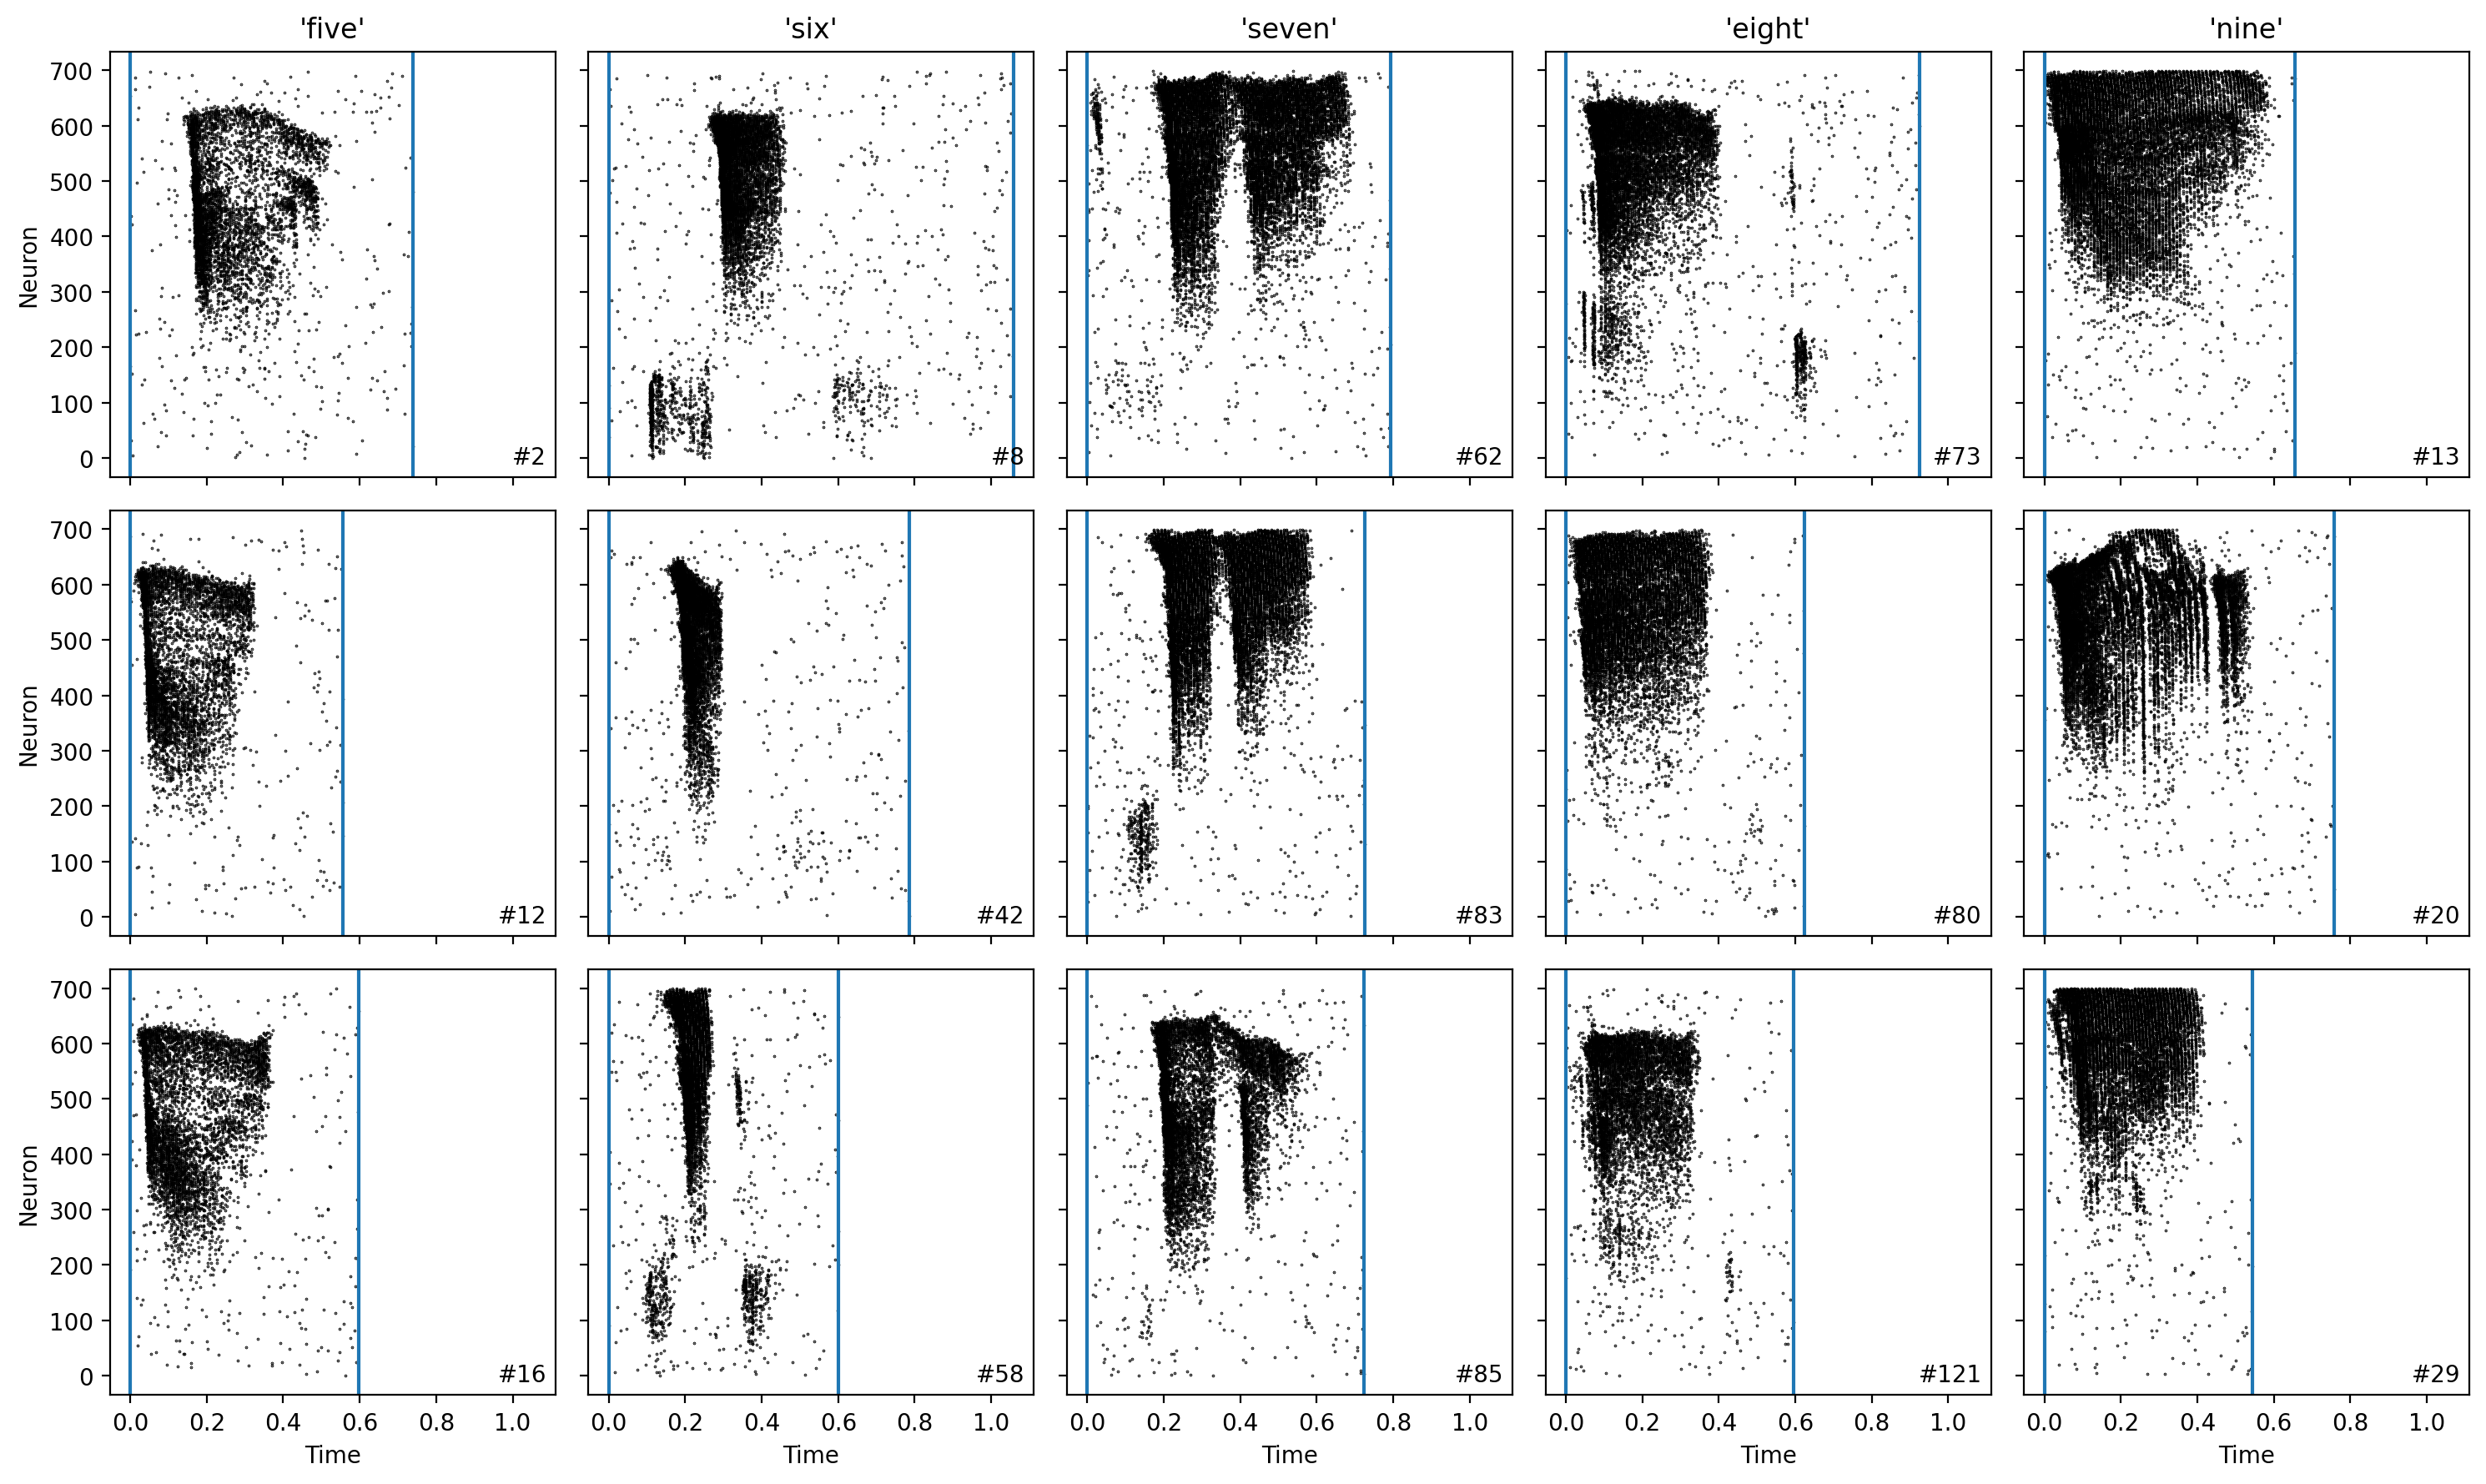

In [6]:
start = 0  # 0 for english, 10 for german
plot_samples(dataset, range(start, start + 5), 3)
plot_samples(dataset, range(start + 5, start + 10), 3)


## Speaker analysis

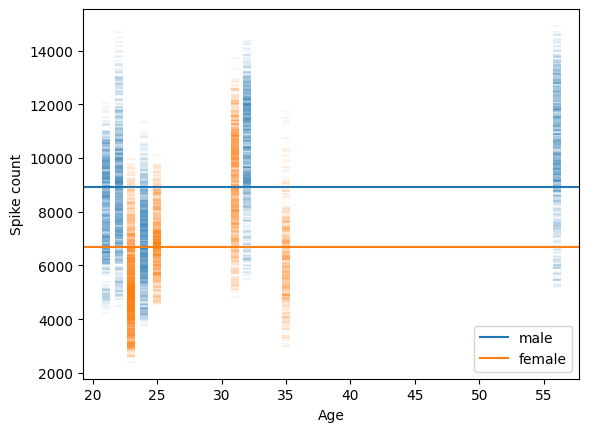

In [7]:
for index, gender in enumerate(["male", "female"]):
    mask = dataset.gender_arr == gender
    color = plt.cm.tab10(index) # type: ignore
    plt.scatter(dataset.age_arr[mask], dataset.spike_count_arr[mask], marker="_", lw=0.1, color=color)
    plt.axhline(dataset.spike_count_arr[mask].mean(), color=color, label=gender)

plt.xlabel("Age")
plt.ylabel("Spike count")
plt.legend()
plt.show()

## Spike rate distribution

Speaker indices with data: [ 0  1  2  3  6  7  8  9 10 11]


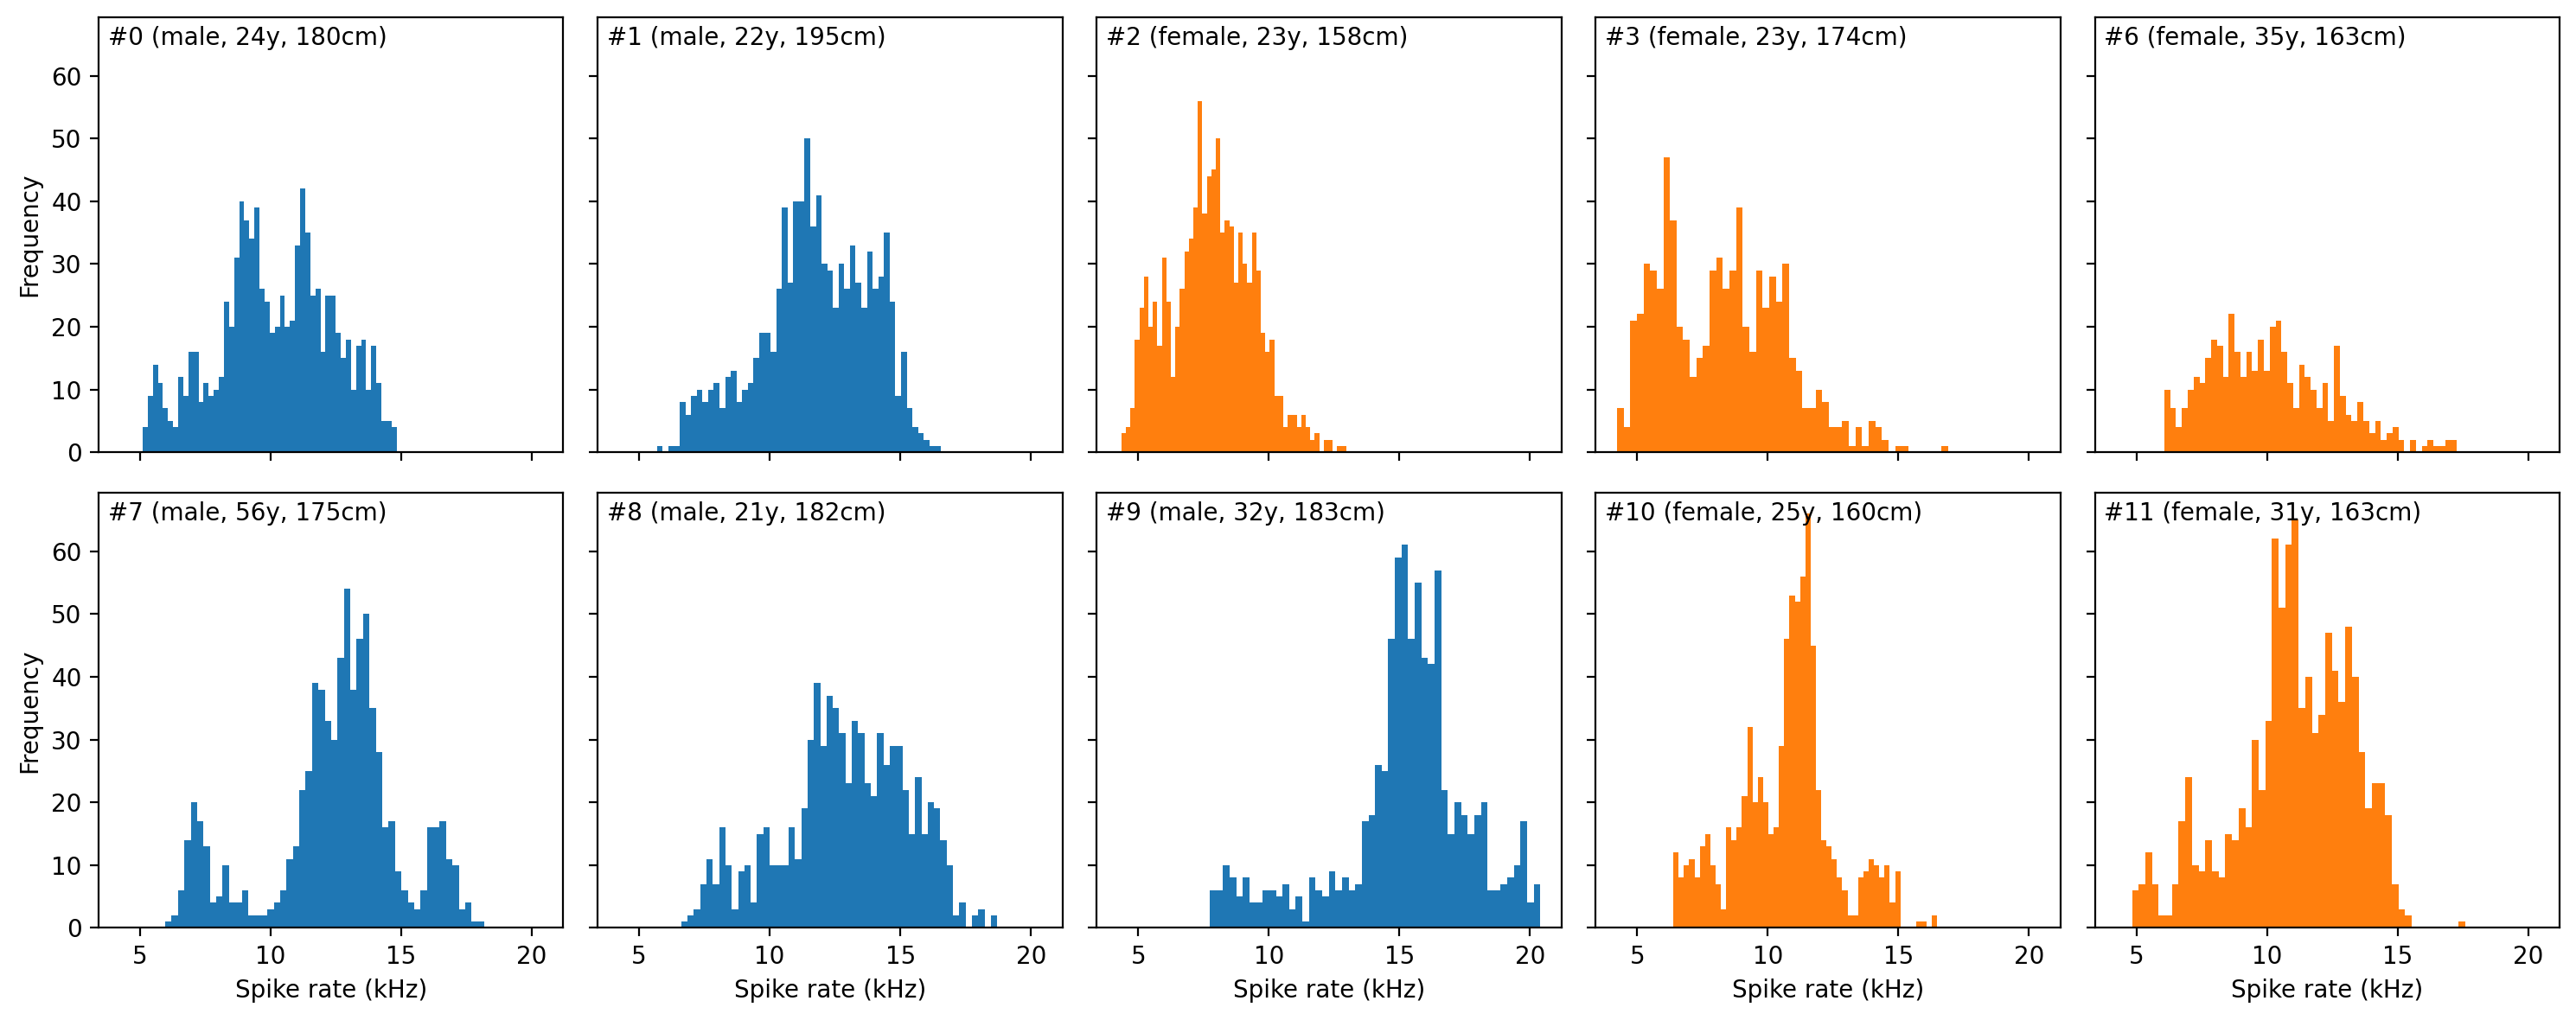

In [8]:
def show_spike_count_hists():
    ncols = 5

    indices = np.unique(dataset.speaker_index_arr)
    print("Speaker indices with data:", indices)
    nrows = (len(indices) + ncols - 1) // ncols

    fig, axs = plt.subplots(
        nrows, ncols, figsize=(ncols * 3, nrows * 3), sharex=True, sharey=True, dpi=200
    )

    for ax, index in zip(axs.flat, indices):
        mask = dataset.speaker_index_arr == index
        gender = dataset.genders_by_speaker[index]
        age = dataset.ages_by_speaker[index]
        height = dataset.body_heights_by_speaker[index]

        color = plt.cm.tab10(["male", "female"].index(gender))  # type: ignore

        ax.hist(dataset.spike_rate_arr[mask] / 1e3, bins=50, color=color)
        ax.text(
            0.02,
            0.98,
            f"#{index} ({gender}, {age}y, {height}cm)",
            transform=ax.transAxes,
            ha="left",
            va="top",
        )

    for ax in axs[-1]:
        ax.set_xlabel("Spike rate (kHz)")

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


show_spike_count_hists()
